# Milestone 1: Getting to know your data, due Wednesday, April 5, 2017

Alexandra Ding, Cynthia He and Jingyi Yu

## Description

In the beginning you should get acquainted with the data sources and do some EDA. Sign up for the TMDb [API](https://www.themoviedb.org/documentation/api), and try to download the poster of your favorite movie from within your notebook. Compare the genre entries of IMDb and TMDb for this movie and see if they are the same. Think about and write down some questions that you would like to answer in the following weeks. Keep the storytelling aspect of your final report in mind and do some pen and paper sketches about the visualizations you would like to produce. Include photographs of those sketches in your notebook. 


Most of the time a data scientist spends on a project is spend on cleaning the data. We are lucky that the data we have is already pretty clean. The Python interface to the IMDb ftp files does a lot of the additional work of cleaning as well. However, you will notice that the genre list for each movie from both databases can have different lengths. This needs to be changed in order to train a model to predict the movie genre. It is up to you to think about possible ways to address this problem and to implement one of them. There is no absolute right answer here. It depends on your interests and which questions you have in mind for the project. 

Optionally, you could also scrape additional data sources, such as Wikipedia, to obtain plot summaries. That data may give you additional useful features for genera classification. 

To guide your decision process, provide at least one visualization of how often genres are mentioned together in pairs. Your visualization should clearly show if a horror romance is more likely to occur in the data than a drama romance.

The notebook to submit for this milestone needs to at least include:

1. API code to access the genre and movie poster path of your favorite movie
2. Genre for this movie listed by TMDb and IMDb
3. A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API
4. Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them 
5. Code to generate the movie genre pairs and a suitable visualization of the result
6. Additional visualization sketches and EDA with a focus on movie genres
7. A list of questions you could answer with this and related data. Get creative here!

The EDA questions do not necessarily have to tie into the modeling part later on. Think freely about things that might be interesting, like which actors are very specific to a genre? Are action movies more prone to producing sequels than romances? However, as you keep the focus on movie genres, think also about correlations you might discover that can help building features from the metadata for prediction. Is the length of a movie title correlated with genre?

### 1. Downloading poster of my favorite movie

In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn visualization package
import pandas as pd
import time
import re # Regex
import collections

# File reading things
import pickle
import json
import csv
import datetime # For handling dates

# The "requests" library makes working with HTTP requests easier
import requests
import os
from bs4 import BeautifulSoup
from IPython.display import Image, display # Display image from URL
from IPython.core.display import HTML # Display image from URL

# TMDB API wrapper
import tmdbsimple as tmdb

# IMDB access
import imdb

# Display options
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
%matplotlib inline

**We picked "Rogue One- Star Wars" as our favorite movie, and used the following API code to access the movie information and poster. **

Below is the search result of "Star Wars"

In [5]:
# os.getcwd()
os.chdir('/Users/AlexandraDing/Desktop')

### Viewing metadata and downloading poster using tmdbsimple API wrapper
# My API key (Lexi)
tmdb.API_KEY = 'ee0df3ce88063f7f6cd466ff61266a55'

# Access configuration to get base_url and file_size
config_url = "https://api.themoviedb.org/3/configuration"
payload = "{}"
response = requests.request("GET", config_url + '?api_key=' + tmdb.API_KEY, data=payload)
base_url =  response.json()['images']['base_url']
poster_sizes = response.json()['images']['poster_sizes']
print(base_url)
print(poster_sizes)

# Search for my favorite movie (Rogue One- Star Wars)
search = tmdb.Search()
response = search.movie(query = "Star Wars")
# Print search results
for s in search.results:
    print s['title'], s['id'], s['release_date']

favorite_movie = tmdb.Movies(330459)
favorite_response = favorite_movie.info()
print(favorite_response)

http://image.tmdb.org/t/p/
[u'w92', u'w154', u'w185', u'w342', u'w500', u'w780', u'original']
Star Wars 11 1977-05-25
Rogue One: A Star Wars Story 330459 2016-12-14
Star Wars: The Force Awakens 140607 2015-12-15
Star Wars: The Last Jedi 181808 2017-12-13
Star Wars: The Clone Wars 12180 2008-08-05
Star Wars: Episode I - The Phantom Menace 1893 1999-05-19
Star Wars: Episode II - Attack of the Clones 1894 2002-05-15
Star Wars: Episode III - Revenge of the Sith 1895 2005-05-17
The Star Wars Holiday Special 74849 1978-12-01
Star Wars: Episode IX 181812 2019-05-23
Star Wars: Clone Wars 420803 2003-11-07
Robot Chicken: Star Wars 42979 2007-07-17
Star Wars: Clone Wars: Volume 2 333365 2005-11-30
The Empire Strikes Back 1891 1980-05-17
Star Wars: Clone Wars: Volume 1 333355 2005-03-21
The Story of Star Wars 435365 2005-08-18
Star Wars: Greatest Moments 378386 2015-12-26
Han Solo: A Star Wars Story 348350 2018-05-24
Star Wars: Heroes & Villains 432134 2005-05-03
Star Wars: TIE Fighter 332479 201

In [14]:
# Request poster from URL: http://stackoverflow.com/questions/30229231/python-save-image-from-url
# (must specify base_url, file_size, poster_path, file_path)
poster_path = favorite_response['poster_path']
poster_size = 'w500'
poster_url = base_url + poster_size + poster_path

# Write poster jpg to cwd
img_data = requests.get(poster_url).content
with open('test_poster.jpg', 'wb') as handler:
    handler.write(img_data)
    
# Display image from URL in IPython Notebook
display(Image(url = poster_url))

### 2. Compare Genres in IMDB and TMDB

In [18]:
# Create the object that will be used to access the IMDb's database.
ia = imdb.IMDb() # by default access the web.

# Search for a movie (get a list of Movie objects).
s_result = ia.search_movie('Star Wars')
# print(s_result)

rogue_one = ia.get_movie('3748528')
print rogue_one['director']
print rogue_one['genre']

# Compare to TMDb
print(favorite_response['genres'])

[<Person id:2284484[http] name:_Edwards, Gareth_>]
[u'Action', u'Adventure', u'Sci-Fi']
[{u'id': 28, u'name': u'Action'}, {u'id': 18, u'name': u'Drama'}, {u'id': 878, u'name': u'Science Fiction'}, {u'id': 10752, u'name': u'War'}]


The genres of Rogue One- Star Wars in these two databases are:

**IMDb: Action, Adventure, Science Fiction;**

**TMDb: Action, Drama, Science Fiction, War.**

The genres are slightly different between the two databases. Most of the labels are the same, but the two databases use different term for some genres, and may have different number of genres in total. 

### 3. Ten most popular movies of 2016 and their Genres (TMDb)
Most popular movies and the genre list were downloaded from TMDb. The genre names were matched to each movie according to the genre ID. 

In [6]:
### Download the genre list from TMDB
url = "https://api.themoviedb.org/3/genre/movie/list?api_key=783918f9b8efd0f2ff0792d7b7de9fa2&language=en-US"

payload = "{}"
response = requests.request("GET", url, data=payload)

# reformat the result
movie_genres = response.json()
movie_genres = movie_genres["genres"]

#Export genre list 
with open("genre_list.csv", "wb") as file:
    csv_file = csv.writer(file) 
    
    # Add column names
    csv_file.writerow(["id", "GenreName"])
    
    for item in movie_genres:
            csv_file.writerow([item['id'], item['name']])

In [9]:
#### Download most popular movies of 2016
# Uses JSON decoder in requests library
# Gets first page of results of sorted descending order popular movies of 2016
A= 'https://api.themoviedb.org/3/discover/movie?api_key=ee0df3ce88063f7f6cd466ff61266a55&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&page=1&primary_release_year=2016'
response = requests.get(A)
response.text
top_movies = response.json()

top_movies_results = top_movies['results']

#### Title and genres of the 10 most popular movies in 2016

In [20]:
# read genre list
genre_names = pd.read_csv("genre_list.csv")
# conver the dataframe into a dictionary
genre_names = genre_names.set_index("id")
genre_name_dict = genre_names.to_dict()['GenreName']

# print genre for the top 10 movies 
for i in range(10):
    # genres for the movie
    genre_ids = top_movies_results[i]["genre_ids"]
    genre_list = list()
    for genre_id in genre_ids:
        genre_list.append(genre_name_dict[genre_id])
        
    # print title and genre of the movie
    print top_movies_results[i]["title"], ":", ", ".join(genre_list) 

Sing : Animation, Comedy, Drama, Family, Music
Fantastic Beasts and Where to Find Them : Adventure, Action, Fantasy
Finding Dory : Adventure, Animation, Comedy, Family
Arrival : Drama, Science Fiction
Deadpool : Action, Adventure, Comedy, Romance
Captain America: Civil War : Action, Science Fiction
Rogue One: A Star Wars Story : Action, Drama, Science Fiction, War
Underworld: Blood Wars : Action, Horror
Doctor Strange : Action, Adventure, Fantasy, Science Fiction
X-Men: Apocalypse : Action, Adventure, Fantasy, Science Fiction


### 4. Challenges for predicting movie genre

In predicting movie genre for our dataset, one of the major challenges is that there are **multiple genres per movie (multilabel dataset)**. In IMDb and TMDb, a single movie can be tagged with different genres between the two databases (for example, in the Star Wars: Rogue One movie above)- we will have to decide how to use these genre labels. In addition, **not all genres are equally frequent** (class imbalance), and in addition, **some genres co-occur with each other**, signifying a possible multicollinearity problem. Our model will need to take into account **dependencies between labels**, as well as incorporate an appropriate loss function. 

To **select features to train the model**, we will have to combat the problem of **high dimensionality**, which results in strain on computing power as well as the ability to fit models. We plan to analyze the movie posters, descriptions, and reviews, incorporating both image and text data into our features. One challenge of the text data available on these databases is that while it is easily accessible via the API, some movies (especially ones produced in different countries or ones that are unpopular) are encoded strangely or are missing different fields- further cleaning or exclusion of this data might be needed. To analyze the text data, addition to running a baseline bag-of-words analysis, we may take into account the relationships between words (such as different synonyms, conjugations, and cognates) or use n-grams (combinations of n adjacent words) as our features. We will examine Latent Dirichlet Allocation to identify words indicative of different movie topics. 

Each database includes multiple years of data, and aggregating all this data into a single analysis may not reflect **time series trends** such as changes in diction (types of words like slang and figure of speech) used in descriptions/reviews of movies produces in different years and trends in genre popularity. To combat this problem, we will consider using a **recent subset of the data** from the past few years, which will hopefully give us enough data to train our model. For example, over 10,000 movies were released in the US in 2016, so using data from the past 5 years may be sufficient to ignore the time series component. 

A final challenge for our prediction is the high demand on **computing power** to run deep learning models. We will be using Amazon AWS as well as considering ways to parallelize our analysis using the MPI package in Python. 

# 5-6. EDV and Visualizations

We explored two sets of data to create the following visualizations. 

### The datasets are:
* **Top 100 movies from 2016 in TMDb**: this is chosen because the movies are easily recognizable for data exploration.


* **Top 20 movies for each genre in TMDb**: this set of data is used for text analysis for each genre. There are at least 20 movies for each genre, and should provide enough preliminary information for our data exploration. 

### The visualizations include:
* Number of movies by release month in 2016
* Number of genres per movie in 100 top movies in 2016
* Number of top 100 movies in each genre in 2016
* Distributions of genres by month in 2016
* Correlation heatmap of genres from top 100 movies in 2016
* Overlap count heatmap of genres from top 100 movies in 2016
* Movie count by language
* Top 10 words in all the top 20 movies for each genre
* Top 3 words for each genre
* Average title length by genre
* Average popularity for each genre
* Average vote counts for each genre




## Load Datasets using TMDB API, and Process Data

We focused on TMDB data for this milestone because it includes movie posters, which will be useful for deep learning. Additional datasets will be added for further analysis later. 

- Notes about nature of data: Data are returned as a JSON file format, which we decided to process into a dict or CSV. 


### Dataset 1: Top 100 movies from 2016

- Used the TMDB API to load the top 100 movies (by popularity) released in 2016 
- Accessed 5 pages of 20 results each, combined data, and saved into a single CSV
- Because one feature (genres) was multilabel, binarized/one-hot encoded values. 

In [22]:
# Need to access 5 pages of 20 results each
page_ns = range(1,6)
    
# Create empty list to store
top_movies_list = [None] * len(page_ns)

for page_n in page_ns:
    url = 'https://api.themoviedb.org/3/discover/movie?api_key=ee0df3ce88063f7f6cd466ff61266a55&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&page='+ str(page_n)+ '&primary_release_year=2016'
    response_page = requests.get(url)
    top_movies_list[page_n-1] = response_page.json()
    
    # pause for 1 sec
    time.sleep(1)

# Convert release_date column to datetime object
top_100_2016['release_date'] = pd.to_datetime(top_100_2016['release_date'], format = '%Y-%m-%d' )

In [59]:
### Save json contents as CSV
with open("top_100_2016_data_with_releasedate.csv", "w") as file:
    csv_file = csv.writer(file)  
    # Add column names
    csv_file.writerow(['poster_path', 'title', 'release_date', 'overview', 'popularity', 'original_title', 'backdrop_path',
                       'vote_count', 'video', 'adult', 'vote_average', 'original_language', 'id', 'genre_ids'])
    # For each item in list, get attributes of movie
    for i in range(5):
        for item in top_movies_list[i]['results']:
            csv_file.writerow([item['poster_path'], item['title'], item['release_date'], item['overview'].encode("utf8"), 
                               item['popularity'], item['original_title'].encode("utf8"), item['backdrop_path'], 
                               item['vote_count'], item['video'], item['adult'], item['vote_average'], 
                               item['original_language'], item['id'], item['genre_ids']])

#### One hot encoding the genres

In [31]:
# Get Genre correspondences and dump
url = "https://api.themoviedb.org/3/genre/movie/list?api_key=783918f9b8efd0f2ff0792d7b7de9fa2&language=en-US"

payload = "{}"
response = requests.request("GET", url, data=payload)

# reformat the result
movie_genres = response.json()

new_dict = {}
for item in movie_genres['genres']:
    name = item['name']
    new_dict[name] = int(item['id'])

print new_dict
# Pickle dump the directory of genres
# pickle.dump(new_dict, open("genre_dict.p", 'wb'))

### Fix the problem in this dataset
n_unique_genres = len(new_dict) # Should be like 19
list_unique_genres = new_dict.values()

# Invert the dict
genre_dict_by_id = {v: k for k, v in new_dict.iteritems()}
# pickle.dump(genre_dict_by_id , open("genre_dict_by_id.p", 'wb'))

print genre_dict_by_id

In [21]:
### Fix formatting errors in genres

# Cnverts entries from this form: '[16, 35, 18, 10751, 10402]' -> [16, 35, 18, 10751, 10402] (list of ints)
top_100_2016['genre_ids'] = [map(int, re.sub("[\[ \] ]", "", top_100_2016['genre_ids'][i]).split(',')) for i in range(len(top_100_2016))]

# http://datascience.stackexchange.com/questions/8253/how-to-binary-encode-multi-valued-categorical-variable-from-pandas-dataframe

data_count_genres = top_100_2016['genre_ids'].apply(collections.Counter)
one_hot_encode_genres = pd.DataFrame.from_records(data_count_genres).fillna(value=int(0))
top_100_2016 = top_100_2016.join(one_hot_encode_genres)

top_100_2016.head(4)

# Write to CSV: top_100_2016_onehot_genres.csv
# top_100_2016.to_csv('top_100_2016_onehot_genres.csv')

### Data 2: 20 movies from each genre

- Used the TMDB API to load the top 20 movies of all time from each genre, and then one-hot encoded the genres
- NOTE ABOUT OVERLAP 
- Encountered problems encoding foreign characters (ex: French words with accents) in one movie in this dataset, so we removed these values. In the future, if we plan to analyze foreign films released in the US as part of our project, we should further research ASCII encoding conventions. Otherwise, because this database includes largely English language films, this issue is rare.

In [27]:
### function to download first 20 movies for a genre
# input: genre id
# output: json file

def get_movie_genre(genre_id):
    
    # construct the url
    url_1 = "https://api.themoviedb.org/3/genre/"
    url_2 = "/movies?api_key=783918f9b8efd0f2ff0792d7b7de9fa2&language=en-US&include_adult=false&sort_by=created_at.asc"
    url =  url_1 + str(genre_id) + url_2
    
    # download the movies
    payload = "{}"
    response = requests.request("GET", url, data=payload)
    
    # convert to json file
    movie_list = response.json()
    movie_list = movie_list["results"]
    
    return movie_list

In [30]:
### download first 20 movies for each genre

# list to store movie lists 
movie_by_genre = list()

for i in range(len(movie_genres)):
    # read genre id
    genre_id = movie_genres[i]["id"]
    
    # download movie list for the genre
    movie_list = get_movie_genre(genre_id)
    movie_by_genre.append(movie_list)
    
    time.sleep(5)
    
    
### replace some data that cause problem

# spot missing values in the data, change it to 'NA'
movie_by_genre[5][17]["overview"] = "NA"
movie_by_genre[5][18]["backdrop_path"] = "NA"

# replace title in French to English (remove \x)
movie_by_genre[5][18]["original_title"] = "Paris est une fxeate - Un film en 18 vagues"
movie_by_genre[5][18]["title"] = "Paris est une fxeate - Un film en 18 vagues"


### Save json contents as CSV

# list of items in the data
features = ['poster_path', 'title', 'overview', 'popularity', 
        'original_title', 'backdrop_path','vote_count', 'video', 
        'adult', 'vote_average', 'original_language', 'id', 'genre_ids',]

# save information into a csv file
with open("movie_by_genres.csv", "wb") as file:
    csv_file = csv.writer(file) 
    
    # Add column names
    csv_file.writerow(features)
    
    # For each item in list, get attributes of movie
    for i in range(len(movie_by_genre)):
        # remove documentary because it has missing values and causes problems
        for item in movie_by_genre[i]:
            csv_file.writerow([item['poster_path'], item['title'], item['overview'].encode("utf8"), 
                               item['popularity'], item['original_title'].encode("utf8"), item['backdrop_path'], 
                               item['vote_count'], item['video'], item['adult'], item['vote_average'],
                               item['original_language'], item['id'], item['genre_ids']])

#### One-hot-encode genres 

In [33]:
# format genre ids into a list of ids
movie_by_genre['genre_ids'] = [map(int, re.sub("[\[ \] ]", "", movie_by_genre['genre_ids'][i]).split(',')) for i in range(movie_by_genre.shape[0])]

# obe-hot-encode genres
data_count_genres = movie_by_genre['genre_ids'].apply(Counter)
one_hot_encode_genres = pd.DataFrame.from_records(data_count_genres).fillna(value=int(0))
movie_by_genre = movie_by_genre.join(one_hot_encode_genres)

# match genre name to the id (using the genre dictionary from above)
movie_by_genre = movie_by_genre.rename(columns = genre_name_dict)

# save the file to a csv
movie_by_genre.to_csv("movie_by_genre_onehot.csv", index = None)

# Visualizations

## Genres of top 100 movies in 2016

- Visualize distribution of genres within our dataset of the top 100 movies of 2016.
- Note: A single movie can have multiple genres (i.e. multilabel classification)
- First, we can print the number of genres per movie. 

### Load the top 100 movies in 2016 for EDA (Generated in above section)

In [45]:
# Lexi Loading Cell
os.chdir('/Users/AlexandraDing/Desktop/cs109b-best-group')

top_100_2016 = pd.read_csv('top_100_2016_onehot_genres.csv')
one_hot_encode_genres = top_100_2016[top_100_2016.columns[-17:]]
one_hot_encode_genres.head(3)

genre_dict_by_id = pickle.load(open('genre_dict_by_id.p', 'rb'))

# Convert keys to int
genre_dict_by_id = {int(k):v for k,v in genre_dict_by_id.items()}
print genre_dict_by_id

# Convert release_date column to datetime object
top_100_2016['release_date'] = pd.to_datetime(top_100_2016['release_date'], format = '%Y-%m-%d' )

n_unique_genres = len(genre_dict_by_id)
list_unique_genres = genre_dict_by_id.values()

{10752: u'War', 80: u'Crime', 10402: u'Music', 35: u'Comedy', 36: u'History', 37: u'Western', 53: u'Thriller', 9648: u'Mystery', 12: u'Adventure', 10770: u'TV Movie', 14: u'Fantasy', 16: u'Animation', 18: u'Drama', 99: u'Documentary', 878: u'Science Fiction', 27: u'Horror', 28: u'Action', 10749: u'Romance', 10751: u'Family'}


### Release Month of the top 100 movies in 2016

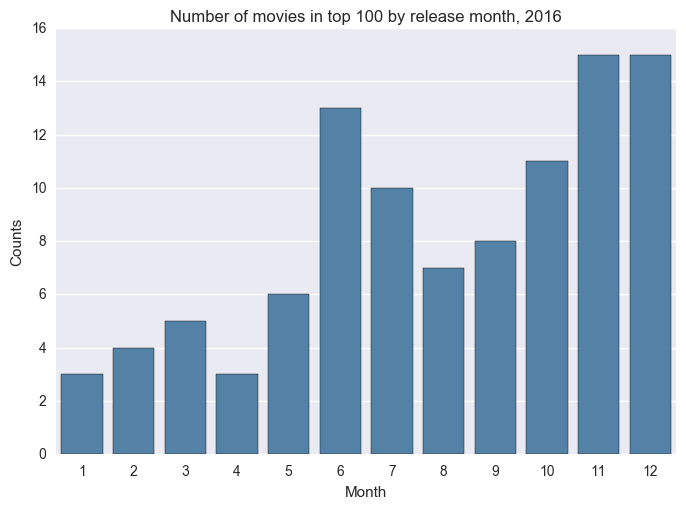

In [43]:
# Plot bar plot of release date (by month)
# http://stackoverflow.com/questions/27365467/python-pandas-plot-histogram-of-dates
counts_by_release_month = top_100_2016['release_date'].groupby(top_100_2016["release_date"].dt.month).count()

sns.set_context({"figure.figsize": (24, 10)})
sns.set(font_scale=1)

plt.figure()
sns.barplot(x = counts_by_release_month.index, 
            y = counts_by_release_month.values, 
            color = 'steelblue')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.title('Number of movies in top 100 by release month, 2016')

### Number of genres per movie in top 100 movies in 2016

From our preliminary exploration, we saw that the Star Wars movie had several associated genres. We can examine how many genres each movie has. Below, we see that within the top 100 movies of 2016, the **average number of genres a movie belongs to is 2.71**. Visualizing the distribution with the barplot, we see that the majority of movies have 2 or 3 genres, with up to 6 for some members of this dataset.

In [7]:
### Count genres

# N genres per entry
print np.sum(one_hot_encode_genres.values, 1)
print 'Average number of genres a movie belongs to:', np.mean(np.sum(one_hot_encode_genres.values, 1))

# N movies per genre
print np.sum(one_hot_encode_genres.values, 0)

print one_hot_encode_genres.columns

[ 5.  3.  4.  4.  4.  2.  4.  2.  2.  4.  2.  3.  4.  4.  1.  4.  1.  3.
  3.  3.  2.  3.  5.  4.  2.  1.  6.  1.  4.  4.  3.  5.  3.  1.  2.  2.
  3.  2.  3.  3.  2.  2.  4.  3.  3.  3.  1.  4.  3.  2.  2.  2.  2.  5.
  3.  1.  4.  4.  4.  3.  3.  2.  5.  3.  1.  1.  4.  3.  3.  2.  1.  3.
  1.  1.  2.  3.  2.  1.  3.  1.  5.  3.  2.  2.  2.  3.  3.  2.  4.  1.
  1.  2.  3.  1.  2.  2.  2.  2.  4.  2.]
Average number of genres a movie belongs to: 2.71
[ 35.  19.  12.  42.   9.  34.  29.   5.   2.  25.  12.  14.   4.   2.  12.
  11.   4.]
Index([u'12', u'14', u'16', u'18', u'27', u'28', u'35', u'36', u'37', u'53', u'80', u'878', u'9648', u'10402', u'10749', u'10751', u'10752'], dtype='object')


[17, 29, 28, 19, 6, 1]
[1, 2, 3, 4, 5, 6]


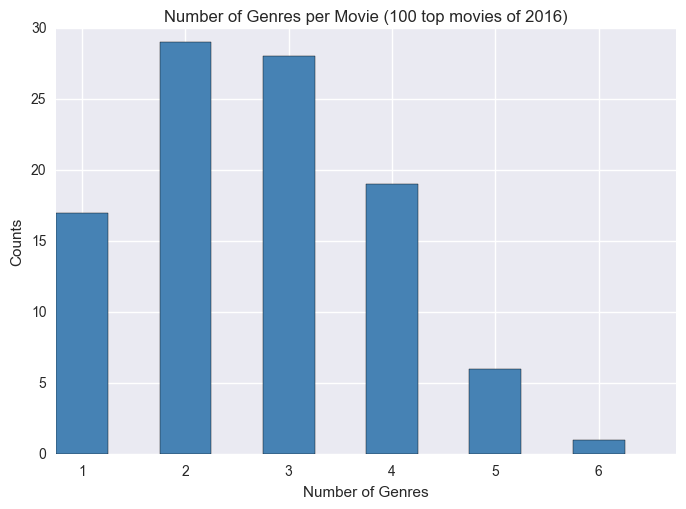

In [104]:
# Create barplot of n genres per movie
hist_genre_count = collections.Counter(np.sum(one_hot_encode_genres.values, 1) )
A = hist_genre_count.values()
B = map(int, hist_genre_count.keys())
print A
print B

sns.set_context({"figure.figsize": (24, 10)})
sns.set(font_scale=1)

fig, ax = plt.subplots()
bar_width = 0.5
ax.bar(B, A, bar_width, color = 'steelblue')
ax.set_xticks(np.array(B) + bar_width/2)
ax.set_xticklabels(B)
plt.ylabel("Counts")
plt.xlabel("Number of Genres")
plt.title("Number of Genres per Movie (100 top movies of 2016)")

### Number of top 100 movies in each genre in 2016

Given our goal to label movies by genre, we could look at which genres are most common in our dataset. We produced a barplot of the number of movies in each genre, in descending order. Our plot shows that the most common genre is Drama followed by Adventure and Action, and that Western and Music are less common labels. Note that because some movies have multiple genres, the counts in this plot will not sum to 100. 

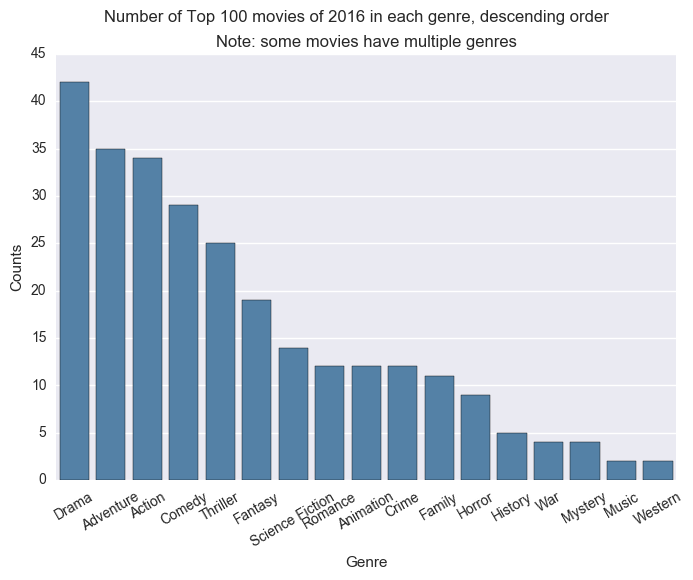

In [105]:

genre_names_encoded = [genre_dict_by_id[int(one_hot_encode_genres.columns[i])] for i in range(len(one_hot_encode_genres.columns))]
genre_counts_df = pd.DataFrame({'genre' :genre_names_encoded, 'counts': np.sum(one_hot_encode_genres.values, 0)})

genre_counts_df_sorted = genre_counts_df.sort_values('counts', ascending = False)

sns.set_context({"figure.figsize": (24, 10)})
sns.set(font_scale=1)
plt.plot()
sns.barplot(x = genre_counts_df_sorted['genre'], 
            y = genre_counts_df_sorted['counts'],
           color = 'steelblue')
plt.xticks(rotation=30)
plt.xlabel('Genre')
plt.ylabel('Counts')
plt.suptitle('Number of Top 100 movies of 2016 in each genre, descending order')
plt.title('Note: some movies have multiple genres')

### Distributions of genres by release month in top 100 movies of 2016

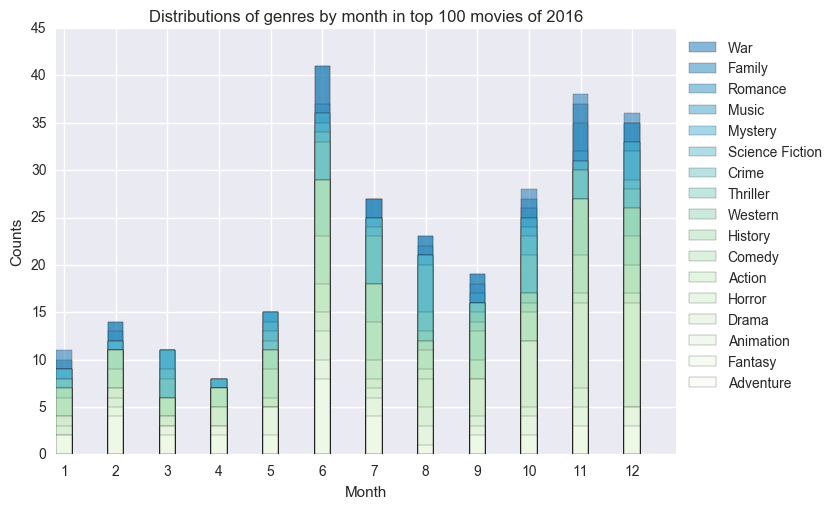

In [99]:
### Get distribution of genres by month
# http://randyzwitch.com/creating-stacked-bar-chart-seaborn/
# First need to count genres by month
sum_genres_by_month = top_100_2016[top_100_2016.columns[-n_unique_genres+1:]].groupby(top_100_2016["release_date"].dt.month).sum()

sum_genres_month_array = np.array(sum_genres_by_month)
cumsum_genres_month_array = np.cumsum(sum_genres_month_array, 1)
#bottom = np.cumsum(ar, axis = 1)
#ind = range(1,5)
#
#plt.bar(ind, ar[0,0], color = 'b')
#for j in xrange(1, ar.shape[1]):
#    plt.bar(ind, ar[j], bottom = bottom[j-1])
#
#
## We have to do dumb things to get a stacked barplot
#f, ax1 = plt.subplots(1, figsize=(10,5))
#bar_width = 0.75


fig, ax = plt.subplots()
sns.set_context({"figure.figsize": (30, 10)})
sns.set(font_scale=1)

ind = np.arange(12)  # the x locations for the groups
width = 0.3  # the width of the bars

gbcolormap = plt.get_cmap('GnBu')
color_list = gbcolormap(np.linspace(0, 1.0, 20))
                 
for i in reversed(range(17)):
    counts_month = cumsum_genres_month_array[:,i]
    rects = ax.bar(ind, counts_month, width, color = color_list[i], alpha = 0.5, label = genre_names_encoded[i])
ax.set_ylabel('Counts')
ax.set_xlabel('Month')
ax.set_title('Distributions of genres by month in top 100 movies of 2016')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(range(1,13))
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

### Distributions of genres by release month in top 100 movies of 2016 - Separated by Genre

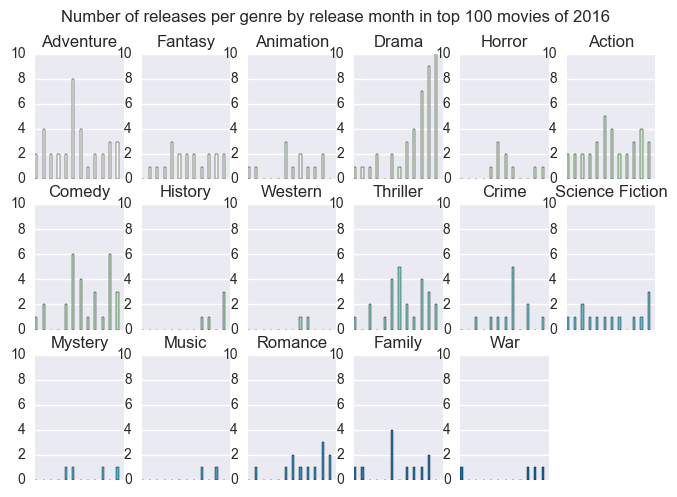

In [103]:
# Genre Subplots
f, axarr = plt.subplots(3, 6)
ax = axarr.flatten()
# sum_genres_by_month
# sum_genres_month_array.shape
for i in range(17):
    ax[i].bar(ind, sum_genres_month_array[:,i], width, color = color_list[i], label = genre_names_encoded[i])
    ax[i].set_title(str(genre_names_encoded[i]))
    
    # Set ylim to 0 to 10 (counts)
    ax[i].set_ylim([0, 10])
    
    # Hide x axis ticks
    ax[i].get_xaxis().set_ticks([])
plt.subplots_adjust(hspace = None)
f.suptitle("Number of releases per genre by release month in top 100 movies of 2016")
f.delaxes(ax[17])

### Correlation heatmap of genres from top 100 movies in 2016

Since each movie may have more than one genre label, it is interesting to explore the relationship between genre. For example, some genres may be paired together more frequently than the others. In other words, knowing one movie belongs a certain genre we can possibly infer that this movie is likely to belong to another genre, which is highly correlated with the known genre. A correlation heatmap is produced to visualize the relationship between genres. The deeper the color tone the strong the correlation.

From the heatmap we can immediately tell that Family and Animation are highly correlated, which makes a lot of sense. Other strongly correlated genres include: Fantasy and Adventure, Family and Adventure, Animation and Comedy, Crime and Thriller, Crime and Mystery, and Comedy and Family.

In [13]:
#load data
os.chdir('/Users/Cynthia9109/Documents/Harvard_Stat/Spring_2017/STAT121B/Project/cs109b-best-group-master')
#data with encoded genres
movie_encoded = pd.read_csv("top_100_2016_onehot_genres.csv")

#subset encoded genre information 
genre = movie_encoded.iloc[:, -17:]
#change columns labels to string
map(int, genre.columns)
genre.columns = map(int, genre.columns)

#change title names to reflect genre
# read the genre list
genre_names = pd.read_csv("genre_list.csv")
# conver the dataframe into a dictionary
genre_names = genre_names.set_index("id")
genre_name_dict = genre_names.to_dict()['GenreName']

# match genre name to the id (using the genre dictionary from above)
genre = genre.rename(columns = genre_name_dict)

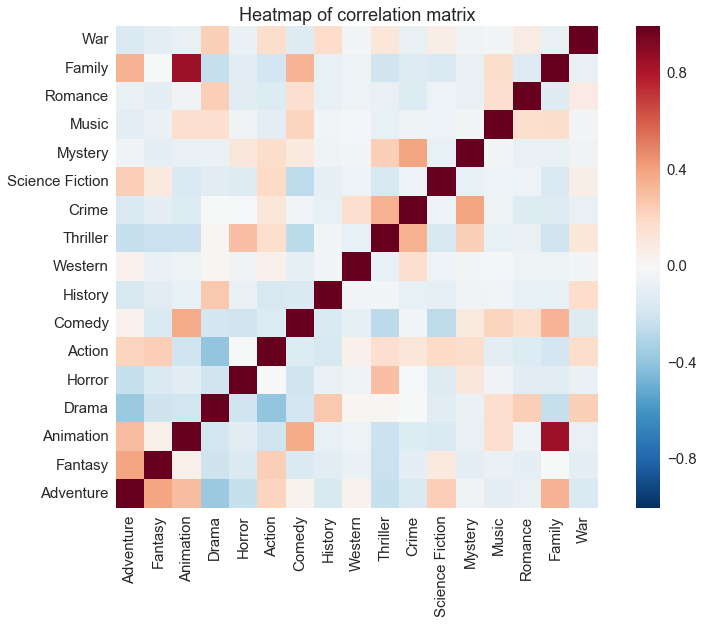

In [25]:
# Compute matrix of correlation coefficients
corrmat = genre.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.set(font_scale=1.5)
sns.heatmap(corrmat, vmax=1, square=True)
ax.invert_yaxis()
ax.set_title('Heatmap of correlation matrix')

f.tight_layout()
plt.show()

### Overlap count heatmap of genres from top 100 movies in 2016

In addition to calculating the correlation between genres, we measured the relationship between genres by counting the number of movies that simultaneously belong to two genres. A heatmap is produced to visualize the count matrix. 

The result here is fairly consistent with the correlation matrix heatmap, although not exactly the same as the number of movies in each genre are different. For example, similar as the correlation matrix, there are a decent number of movies that are labeled as both Animation and Family. We see more movies labeled as both Action and Adventure compared to the number of movies labeled as both Family and Comedy, even though Family and Comedy has a stronger correlation based on the correlation matrix. It is probably because there are more Adventure movies than Family movies.

In [15]:
#create zero mtrix
n = genre.shape[1]
countmat = np.zeros(shape=(n,n))

#create a count matrix
for i in range(n):
    for j in range(n):
        #count for the number of movies with both labels
        countmat[i,j] = sum(genre[[i]].values * genre[[j]].values)

#convert the matrix to a dataframe  
countmat_df = pd.DataFrame(data = countmat, index = corrmat.index, columns = corrmat.columns)

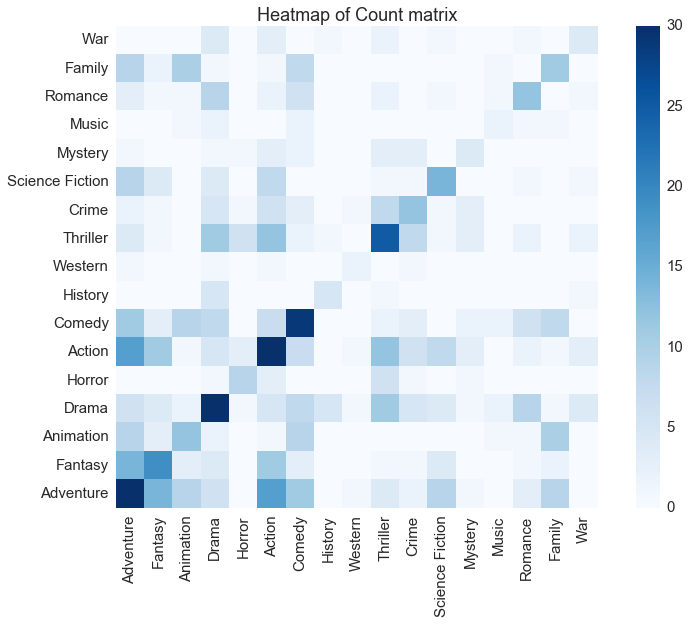

In [29]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(countmat_df, vmax= 30, square=True, cmap = "Blues")
ax.invert_yaxis()
ax.set_title('Heatmap of Count matrix')

f.tight_layout()
plt.show()

### Movie count by language

For exploratory data analysis, we are interested in the movie distribution across different original languages. Without surprise the majority of the movies are produced in English, and only 5% of our sample were produced in languages other than English. Due to the dominance of English movies and the insufficient sample size of movies of other languages, we will only analyze movies with original language as English in the future step of this study.  

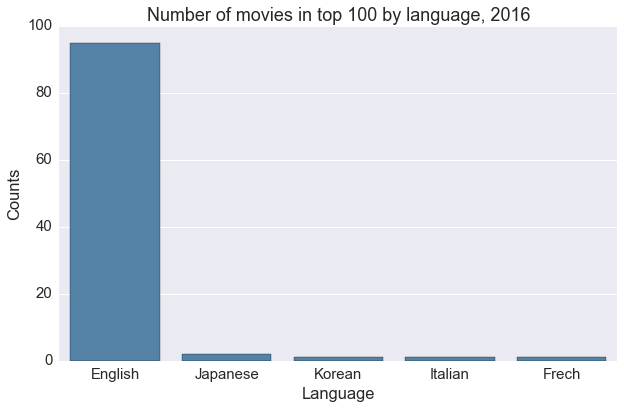

In [12]:
#count movie by original language
count_bylanguage = movie_encoded['original_language'].value_counts()

# draw bar plot
sns.set(font_scale=1.5)
sns.set_context({"figure.figsize": (10, 6)})
plt.figure()
ax = sns.barplot(x = count_bylanguage.index, 
            y = count_bylanguage.values, 
            color = "steelblue")

ax.set_xticklabels(['English', 'Japanese', 'Korean', 'Italian', 'Frech'])

plt.xlabel('Language')
plt.ylabel('Counts')
plt.title('Number of movies in top 100 by language, 2016')


## Characteristics of Movie Genres
Next, we explored the difference among movie genres. In order to make sure there are enough data to represent each genre, we downloaded 20 movies for each genre for this analysis. (Duplicates due to movies on the list of more than one genre were removed.) 

### Load the data including 20 movies by genre for EDA (Generated in above section)

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# read the one-hot-encoded data
movie_by_genre = pd.read_csv("movie_by_genre_onehot.csv")

###  Top 3 most popular words in movie titles of each genre
The movies in different genres may tend to use different types of words in the titles. To explore this possibility, we used bag-of-words to analyze all the movie titles, and listed the top 3 words with the highest counts in each genre 

In [7]:
# apply bag-of-words to movie titles
# eliminate common stop words
vectorizer = CountVectorizer(stop_words='english')

# apply to movie titles
corpus = movie_by_genre['title'].values
title_counts = vectorizer.fit_transform(corpus)
# convert to array
title_counts = title_counts.toarray()

# word list
title_words = vectorizer.get_feature_names()
title_words = np.asarray(title_words)

In [8]:
# read the genre list
genre_names = pd.read_csv("genre_list.csv")

# find the most popular n words for each genre
n = 3 # find 3 words
words_by_genre = list() #store words for each genre

for genre in genre_names['GenreName']:
    # count movies in this genre
    counts_by_genre = np.sum(title_counts[movie_by_genre[genre].values == 1, :], axis = 0)

    # sort from higher to lower counts
    sort_genre = np.argsort(counts_by_genre) # ascending order
    sort_genre = sort_genre[::-1] # descending order

    # return the words of top n words
    words = ", ".join(title_words[sort_genre[:n]])
    words_by_genre.append(words)

In [9]:
# organize the result
pop_word_genre = pd.DataFrame({
        "Genre": genre_names['GenreName'],
        "Popular words": words_by_genre
    })

pop_word_genre

,Genre,Popular words
0,Action,"dawn, wars, men"
1,Adventure,"harry, potter, men"
2,Animation,"ice, age, finding"
3,Comedy,"rock, mutant, la"
4,Crime,"knight, dark, return"
5,Documentary,"brick, love, reverie"
6,Drama,"girl, king, knight"
7,Family,"harry, potter, ice"
8,Fantasy,"potter, harry, men"
9,History,"king, time, ridge"


The popular words for each genre makes intuitive sense. The words are either associated with the genre, or related to famous movies of that genre. For example, the popular Harry Potter movies can be classified into Family, Adventure and Fantasy, and the words "harry" and "potter" are top words for these genres. 

### Average title length by genre
In addition, we also explored if the title length might be different among genres. The result suggests that most genres have similar title length of 2-3 words. TV movies tends to have longer titles. 

In [19]:
### count title length for each movie

# list to store title length by movie
title_length = list()

# count title length for each movie
for title in movie_by_genre['title']:
    title_length.append(len(title.split(" ")))
    
# add title length to the data
movie_by_genre['title_length'] = title_length

In [20]:
### Count average title length and SE for each genre

# lists to store the results
title_genre = list()   # average title length
title_se = list()    # standard error of title length

# for each genre
for genre in genre_names['GenreName']:
    # movies in this genre
    movie_genre = movie_by_genre.iloc[movie_by_genre[genre].values == 1]

    # commpute average title length
    title_genre.append(movie_genre['title_length'].mean())
    # standard error of popularity
    title_se.append(movie_genre['title_length'].std()/np.sqrt(len(movie_genre['title_length'])))

(0, 19)

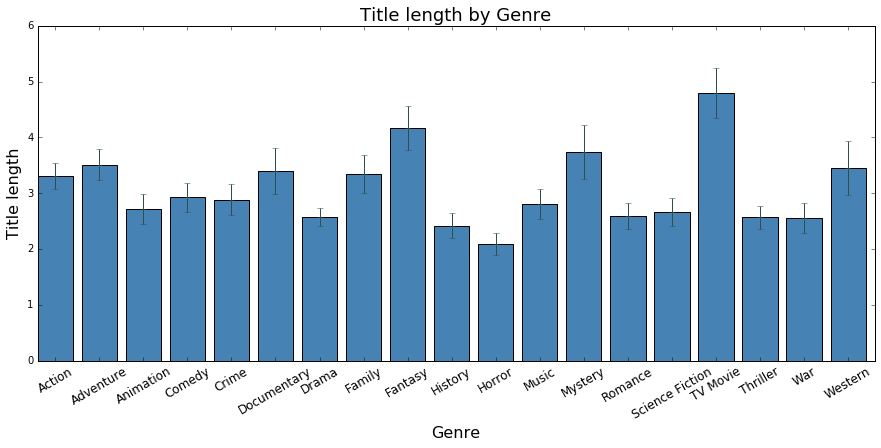

In [22]:
# generate the bar plots
fig = plt.figure(figsize = (15, 6))

# add title length by genre
ax1 = fig.add_subplot(111)
ax1.bar(bar, title_genre, color = "steelblue")
plt.errorbar(tickers, title_genre, yerr=title_se, fmt = '_', color = "darkslategray")

plt.xticks(tickers, genre_names['GenreName'], rotation = 30, fontsize = 12)
ax1.set_title("Title length by Genre", fontsize = 18)
ax1.set_xlabel("Genre", fontsize = 16)
ax1.set_ylabel("Title length", fontsize = 16)
ax1.set_xlim([0, 19])

### Popularity, average votes for each genre
The popularity score and average vote for each movie indicates how much people watch and like the movie. The average popularity and vote are plotted for each genre. The standard errors of the group popularity are also labelled on the plot. The standard error of average vote by genre is not included due to its relatively large scale compared to the average votes. 

In [16]:
### compute average popularity and vote for each genre
num_genre = genre_names.shape[0]

# lists to store the results
popularity_genre = list()   # average popularity
popularity_se = list()    # standard error of popularity
vote_genre = list()   # average vote
vote_se = list()     # standard error of average vote

# for each genre
for genre in genre_names['GenreName']:
    # movies in this genre
    movie_genre = movie_by_genre.iloc[movie_by_genre[genre].values == 1]

    # commpute average popularity
    popularity_genre.append(movie_genre['popularity'].mean())
    # standard error of popularity
    popularity_se.append(movie_genre['popularity'].std()/np.sqrt(len(movie_genre['popularity'])))
    
    # commpute average vote
    vote_genre.append(movie_genre['vote_average'].mean())
    # standard error of average vote
    vote_se.append(movie_genre['vote_average'].std()/np.sqrt(len(movie_genre['vote_average'])))

(0, 19)

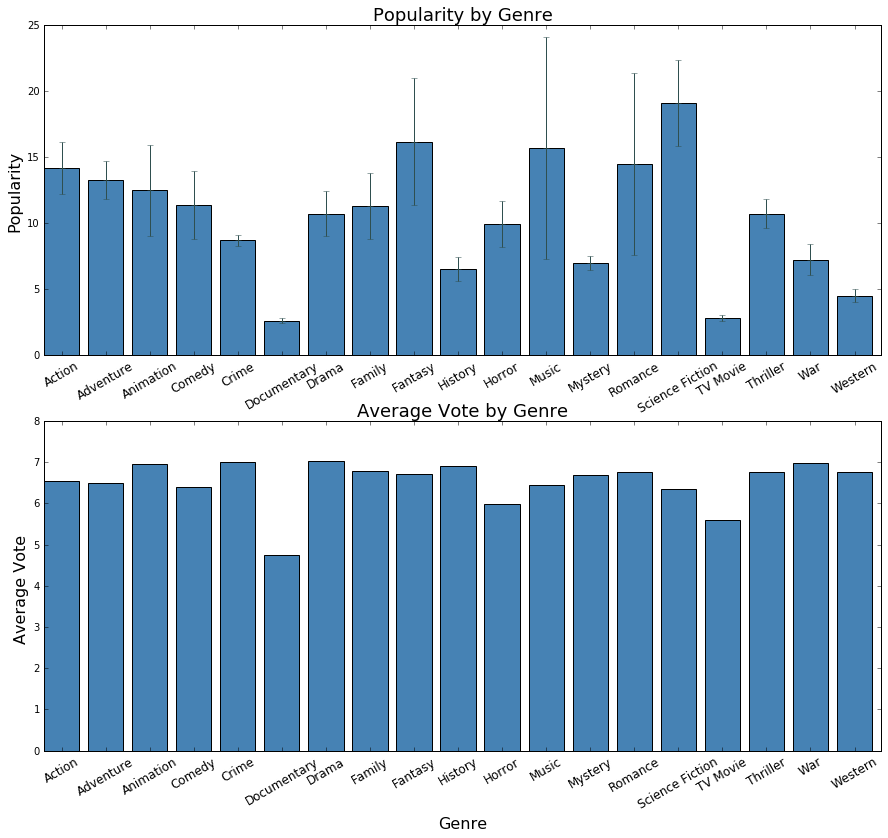

In [18]:
# generate the bar plots
fig = plt.figure(figsize = (15, 13))

# create the locations of the bars
bar = np.arange(num_genre)
bar_width = 0.8
tickers = [i + 0.5*(bar_width) for i in bar] 

# add subplot of average popularity
ax1 = fig.add_subplot(211)
ax1.bar(bar, popularity_genre, color = "steelblue")
plt.errorbar(tickers, popularity_genre, yerr=popularity_se, fmt = '_', color = "darkslategray")

plt.xticks(tickers, genre_names['GenreName'], rotation = 30, fontsize = 12)
ax1.set_title("Popularity by Genre", fontsize = 18)
ax1.set_xlabel("Genre", fontsize = 16)
ax1.set_ylabel("Popularity", fontsize = 16)
ax1.set_xlim([0, 19])

# add subplot of average vote
ax2 = fig.add_subplot(212)
ax2.bar(bar, vote_genre, color = "steelblue")
# large error bar, not included
#plt.errorbar(tickers,  vote_genre, yerr=vote_se, fmt = '_')

plt.xticks(tickers, genre_names['GenreName'], rotation = 30, fontsize = 12)
ax2.set_title("Average Vote by Genre", fontsize = 18)
ax2.set_xlabel("Genre", fontsize = 16)
ax2.set_ylabel("Average Vote ", fontsize = 16)
ax2.set_xlim([0, 19])


The popularity varies greatly among genres. Science fiction, fantasy romance and music movies are the most popular genres. Documentary and TV movies are the least popular genres. In addition, the large error bar for music movies suggests that the popularity varies a lot in this group.  

Most genres have similar average votes, except that documentary movies have lower average votes compared to other genres.

## Sketches for additional visualizations
### Using movie poster features to classify movie genres

![poster](IMG_8460.jpg?fixOrientation)


### Using text analysis to classify movie genres

![text analysis](text_scatches.jpg)

### 7. A list of questions you could answer with this and related data.

Genre: 
- Classify movie genres using other information of the movie such as title, description, cast, popularity and vote, whether the movie is a sequel, revenue and budget of the movie, release time and duration, etc.  

Posters: There are additional questions can be answered by information in the posters. Several examples are listed below.
- Predict movie genre and popularity by the number of objects in its posters.
- Whether expression of people on the posters is predictive of the movie genre, for example horror movies may have different facial expressions from romance movies. And whether the correlation between poster facial expressions and movie genres can predict the revenue of the movie. 
- Whether computer generated pictures can be predictive of some movie genres.


Vote/Popularity/Rating: 
- Use movie features and poster analysis to predict movie rating/popularity
- Movie features include: movie cast - director and actors, duration, time of release, movie description, budget, box office, whether it is a sequel, screen ratio (whether it is IMAX), rating restriction 
- Poster analysis: number of faces in the poster, facial expression, male/female percentage, RGB balance, illuminance balance, font and size of poster text, number of  object in posters

Revenue:
- Use movie features and poster analysis to predict movie revenue. This can be done in a similar fashion as predicting popularity.

Time Series Trends: 
- Dataset spans multiple years of movie releases (from pre- 1950s to current day)
- Analyze popularity of different genres over time + common words in descriptions (for example, expected that superhero movies  and computer-animated movies would increase in frequency over time)
- Text analysis: look at common words used in reviews and descriptions to identify popular topics
- Correlate trends in movie genres, movie popularity with changing demographics of moviegoers over time, economic conditions (for example, movie industry is currently in decline due to reduced viewership, and the types of movies that are popular in different decades might change based on who is coming to theaters)

Reviews (Text analysis): 
- Compare contents of reviews from critics vs. general users 
- Correlation of rating of Critics vs. Users (overall and by genre)
- Identify key words and topics mentioned by reviews (for example, critics may focus on different aspects of movie than general users)
- See if critic reviews are better predictive of whether a movie gets awards/nominations than user reviews (would have to scrape additional pages such as Wikipedia descriptions)

Other sources of data to consider:
- Wikipedia
- Award Websites 
- Rotten Tomatoes (other review websites)
- User demographics
- Social media popularity - facebook likes
- Google search volume - movie, actors and directors
